# <h1 style="font-size:2.5em;">Financial Data Analysis using Yahoo Finance API</h1>

This notebook demonstrates the process of downloading and analyzing financial data using the Yahoo Finance API, as well as performing cointegration tests among various financial instruments. The primary focus is on a wide range of assets, including cryptocurrencies, bank stocks, global indexes, tech stocks, consumer goods stocks, and bonds.

<h2 style="font-size:2em;">Steps Covered:</h2>

1. **Library Imports**: Importing necessary libraries for data download, manipulation, visualization, and statistical analysis.
2. **Parameter Initialization**: Defining parameters such as date range, p-value threshold for cointegration tests, and transaction costs.
3. **Universe Definition**: Specifying the list of tickers to be analyzed, categorized into different asset classes.
4. **Data Download**: Using Yahoo Finance API to download historical data for the defined tickers within the specified date range.
5. **Data Preparation**: Organizing the downloaded data for further analysis.

The code below sets up the environment and downloads the required financial data for analysis.



In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import coint
from itertools import combinations
import seaborn as sns

START_DATE = '2021-01-01'
END_DATE = '2023-10-31'
P_VALUE_THRESHOLD = 0.02
TRANSACTION_COST = 0.001

crypto_forex_stocks = ['BTC-USD', 'ETH-USD', 'BNB-USD', 'XRP-USD', 'ADA-USD', 'DOGE-USD', 'ETC-USD', 'XLM-USD', 'AAVE-USD', 'EOS-USD', 'XTZ-USD', 'ALGO-USD', 'XMR-USD', 'KCS-USD', 'MKR-USD', 'BSV-USD', 'RUNE-USD', 'DASH-USD', 'KAVA-USD', 'ICX-USD', 'LINA-USD', 'WAXP-USD', 'LSK-USD', 'EWT-USD', 'XCN-USD', 'HIVE-USD', 'FTX-USD', 'RVN-USD', 'SXP-USD', 'BTCB-USD']
bank_stocks = ['JPM', 'BAC', 'WFC', 'C', 'GS', 'MS', 'DB', 'UBS', 'BBVA', 'SAN', 'ING', 'BNPQY', 'HSBC', 'SMFG', 'PNC', 'USB', 'BK', 'STT', 'KEY', 'RF', 'HBAN', 'FITB', 'CFG', 'BLK', 'ALLY', 'MTB', 'NBHC', 'ZION', 'FFIN', 'FHN', 'UBSI', 'WAL', 'PACW', 'SBCF', 'TCBI', 'BOKF', 'PFG', 'GBCI', 'TFC', 'CFR', 'UMBF', 'SPFI', 'FULT', 'ONB', 'INDB', 'IBOC', 'HOMB']
global_indexes = ['^DJI', '^IXIC', '^GSPC', '^FTSE', '^N225', '^HSI', '^AXJO', '^KS11', '^BFX', '^N100', '^RUT', '^VIX', '^TNX']
tech_stocks = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'FB', 'NVDA', 'TSLA', 'NFLX', 'ADBE', 'ORCL', 'CSCO', 'INTC', 'AMD', 'IBM', 'CRM', 'QCOM', 'TXN', 'SAP', 'INTU', 'VMW']
consumer_goods_stocks = ['PG', 'KO', 'PEP', 'PM', 'UL', 'MO', 'CL', 'KMB', 'COST', 'WMT', 'TGT', 'MCD', 'SBUX', 'NKE', 'DIS', 'HD', 'PFE', 'MRK', 'JNJ', 'ABBV']
bonds = ['TLT', 'IEF', 'BND', 'AGG', 'SHY', 'LQD', 'HYG']

universe_tickers = crypto_forex_stocks + bank_stocks + global_indexes + tech_stocks + consumer_goods_stocks + bonds

def load_ticker_ts_df(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

universe_tickers_ts_map = {ticker: load_ticker_ts_df(ticker, START_DATE, END_DATE) for ticker in universe_tickers}



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

<h2 style="font-size:2.5em;">Data Sanitization</h2>

This section outlines the data sanitization process to ensure the financial data is clean and ready for analysis. The `sanitize_data` function takes the raw data map and performs the following steps:

1. **Define Parameters**: Calculate the total length of the time series in days and create a date range from the start to the end date.
2. **Filter and Adjust Data**: Iterate through the data map, filter out incomplete datasets, and adjust the length of the data to match the specified date range.
3. **Handle Missing and Infinite Values**: Replace infinite values with NaN, interpolate missing values linearly, and fill remaining NaNs with forward and backward fill methods.
4. **Validation**: Ensure the final data does not contain any NaN or infinite values.

The sanitized data is then returned for further analysis.

In [2]:
def sanitize_data(data_map):
    TS_DAYS_LENGTH = (pd.to_datetime(END_DATE) - pd.to_datetime(START_DATE)).days
    data_sanitized = {}
    date_range = pd.date_range(start=START_DATE, end=END_DATE, freq='D')

    for ticker, data in data_map.items():
        if data is None or len(data) < (TS_DAYS_LENGTH / 2):
            continue
        if len(data) > TS_DAYS_LENGTH:
            data = data[-TS_DAYS_LENGTH:]
        data = data.reindex(date_range)
        data['Adj Close'].replace([np.inf, -np.inf], np.nan, inplace=True)
        data['Adj Close'].interpolate(method='linear', inplace=True)
        data['Adj Close'].fillna(method='pad', inplace=True)
        data['Adj Close'].fillna(method='bfill', inplace=True)
        if not np.any(np.isnan(data['Adj Close'])) and not np.any(np.isinf(data['Adj Close'])):
            data_sanitized[ticker] = data

    return data_sanitized


<h2 style="font-size:2.5em;">Cointegration Analysis and Pair Trading Strategy</h2>

In this section, we perform cointegration analysis on the sanitized financial data to identify potential trading pairs. The identified pairs are then used to generate trading signals and backtest a pair trading strategy.

<h3 style="font-size:2em;">Steps Covered:</h3>

1. **Sanitize Data**: Clean and prepare the financial data for analysis.
2. **Find Cointegrated Pairs**: Identify pairs of assets that are cointegrated, using a specified p-value threshold.
3. **Visualize Cointegration**: Create a heatmap to visualize the cointegration p-values among the assets.
4. **Generate Trading Signals**: Develop trading signals based on the spread and z-score of the cointegrated pairs.
5. **Backtest Strategy**: Evaluate the performance of the pair trading strategy using historical data.



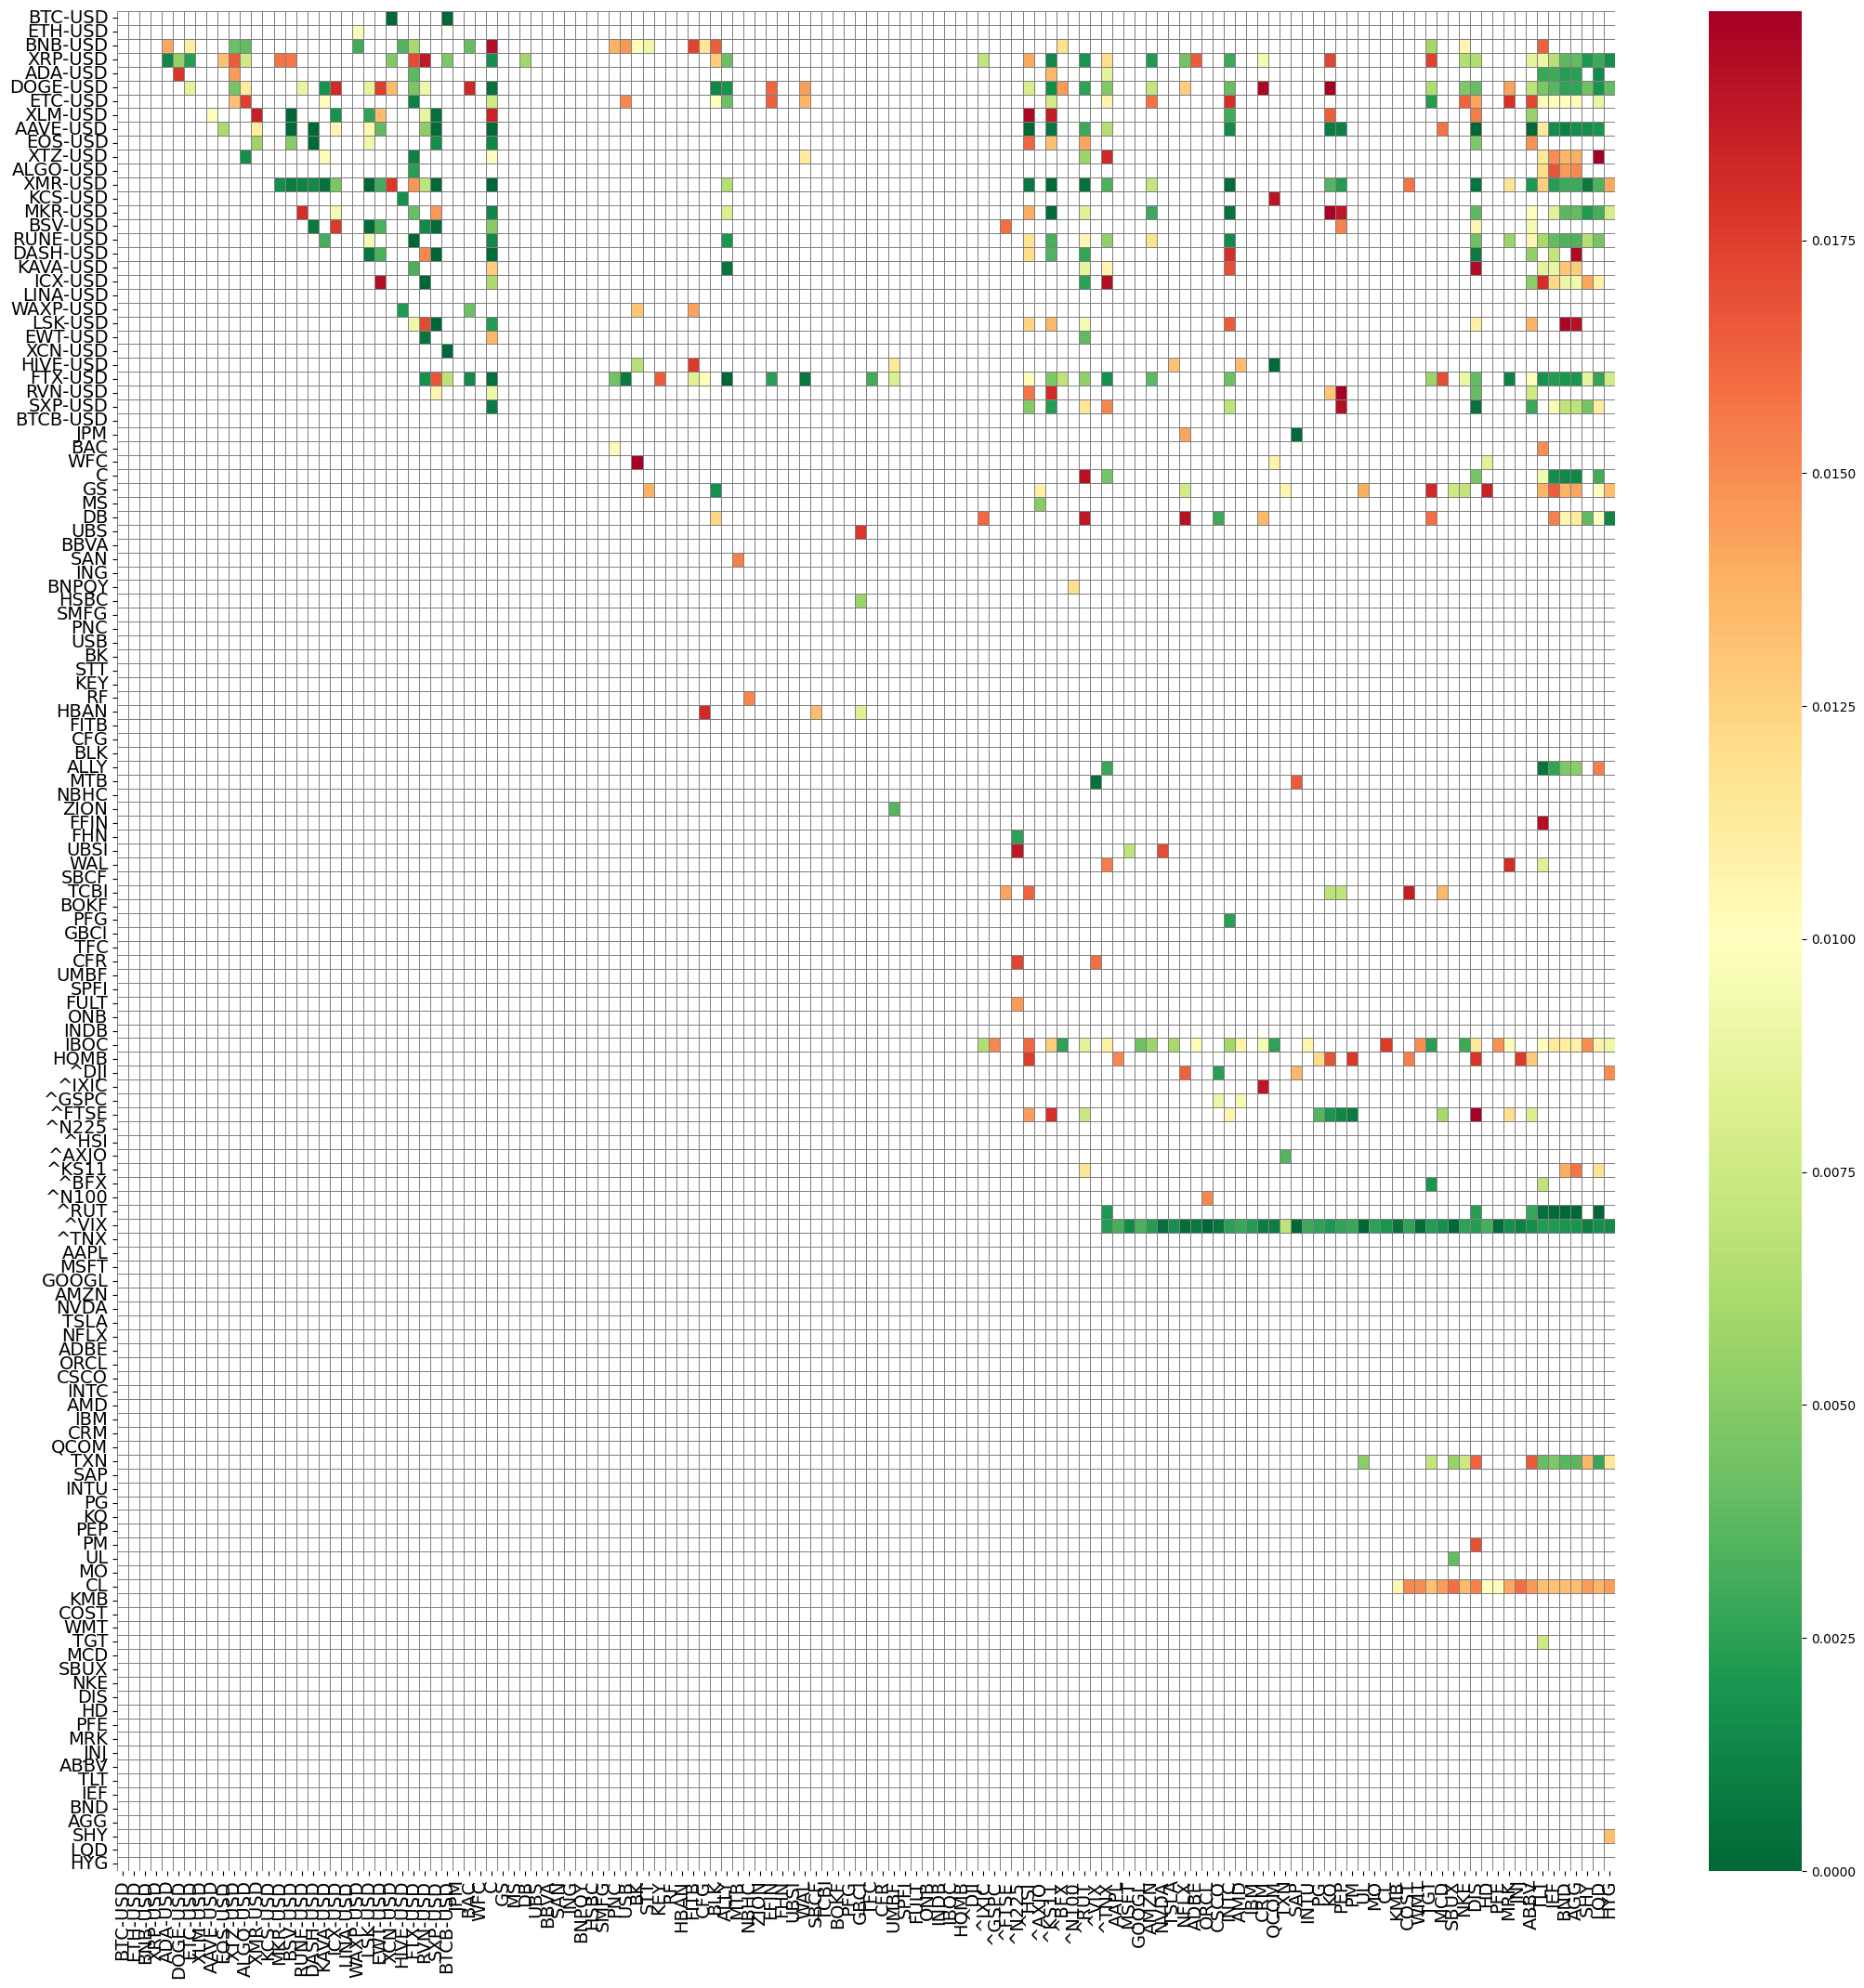

In [3]:

 uts_sanitized = sanitize_data(universe_tickers_ts_map)
def find_cointegrated_pairs(tickers_ts_map, p_value_threshold=0.2):
    tickers = list(tickers_ts_map.keys())
    n = len(tickers)
    adj_close_data = np.column_stack([tickers_ts_map[ticker]['Adj Close'].values for ticker in tickers])
    pvalue_matrix = np.ones((n, n))

    for i, j in combinations(range(n), 2):
        result = coint(adj_close_data[:, i], adj_close_data[:, j])
        pvalue_matrix[i, j] = result[1]

    pairs = [(tickers[i], tickers[j], pvalue_matrix[i, j]) for i, j in combinations(range(n), 2) if pvalue_matrix[i, j] < p_value_threshold]

    return pvalue_matrix, pairs

pvalues, pairs = find_cointegrated_pairs(uts_sanitized, p_value_threshold=P_VALUE_THRESHOLD)

plt.figure(figsize=(26, 26))
heatmap = sns.heatmap(pvalues, xticklabels=uts_sanitized.keys(), yticklabels=uts_sanitized.keys(), cmap='RdYlGn_r', mask=(pvalues > (P_VALUE_THRESHOLD)), linecolor='gray', linewidths=0.5)
heatmap.set_xticklabels(heatmap.get_xticklabels(), size=14)
heatmap.set_yticklabels(heatmap.get_yticklabels(), size=14)
plt.show()

def generate_signals(data_sanitized, pair, entry_threshold, exit_threshold=0):
    ticker1, ticker2 = pair[:2]
    spread = data_sanitized[ticker1]['Adj Close'] - data_sanitized[ticker2]['Adj Close']
    zscore = (spread - spread.mean()) / spread.std()

    signals = pd.DataFrame(index=spread.index)
    signals['long'] = zscore < -entry_threshold
    signals['short'] = zscore > entry_threshold
    signals['exit'] = (zscore < exit_threshold) & (zscore > -exit_threshold)

    return signals

def backtest_strategy(data_sanitized, pair, signals, transaction_costs=0):
    ticker1, ticker2 = pair[:2]
    positions = pd.DataFrame(index=signals.index)
    positions[ticker1] = 0
    positions[ticker2] = 0

    positions.loc[signals['long'], ticker1] = 1
    positions.loc[signals['long'], ticker2] = -1
    positions.loc[signals['short'], ticker1] = -1
    positions.loc[signals['short'], ticker2] = 1
    positions.loc[signals['exit'], [ticker1, ticker2]] = 0

    positions = positions.fillna(method='ffill')

    returns = pd.DataFrame(index=signals.index)
    returns[ticker1] = data_sanitized[ticker1]['Adj Close'].pct_change()
    returns[ticker2] = data_sanitized[ticker2]['Adj Close'].pct_change()

    strategy_returns = (positions.shift(1) * returns).sum(axis=1)
    strategy_returns -= transaction_costs * positions.diff().abs().sum(axis=1)

    strategy_returns.replace([np.inf, -np.inf], np.nan, inplace=True)
    strategy_returns.dropna(inplace=True)

    cumulative_returns = (1 + strategy_returns).cumprod() - 1

    mean_return = strategy_returns.mean()
    std_return = strategy_returns.std()

    if std_return == 0 or np.isnan(std_return):
        sharpe_ratio = 0
    else:
        sharpe_ratio = mean_return / std_return * np.sqrt(252)

    return cumulative_returns, sharpe_ratio, positions

<div>
    <h1 style="font-size: 24px; font-weight: bold;">Optimizing Trading Strategy Parameters</h1>
    <p style="font-size: 16px;">In this analysis, we aim to optimize parameters for a trading strategy using pairs of assets.</p>
    <p style="font-size: 16px;">Steps involved:</p>
    <ol style="font-size: 16px;">
        <li>Define function to optimize parameters based on Sharpe ratio.</li>
        <li>Evaluate multiple pairs and entry thresholds.</li>
        <li>Calculate cumulative returns and Sharpe ratio for each pair.</li>
        <li>Select the pair with the highest Sharpe ratio and its associated parameters.</li>
        <li>Plot the cumulative returns over time for the selected pair.</li>
    </ol>
    <p style="font-size: 16px;">This analysis helps in identifying the optimal trading strategy based on historical data.</p>
</div>


Best Pair: {'pair': ('BTC-USD', 'BTCB-USD'), 'entry_threshold': 0.1, 'sharpe_ratio': 3.365352443463978, 'cumulative_returns': 2021-01-01    0.000000
2021-01-02   -0.073108
2021-01-03   -0.044948
2021-01-04    0.028359
2021-01-05    0.028359
                ...   
2023-10-27    5.493029
2023-10-28    5.493029
2023-10-29    5.491298
2023-10-30    5.494267
2023-10-31    5.494267
Freq: D, Length: 1034, dtype: float64, 'positions':             BTC-USD  BTCB-USD
2021-01-01       -1         1
2021-01-02       -1         1
2021-01-03       -1         1
2021-01-04        0         0
2021-01-05        1        -1
...             ...       ...
2023-10-27        0         0
2023-10-28        1        -1
2023-10-29        1        -1
2023-10-30        1        -1
2023-10-31        1        -1

[1034 rows x 2 columns]}
Overall Cumulative Returns: 17276.836541802495
Best Sharpe Ratio: 3.365352443463978


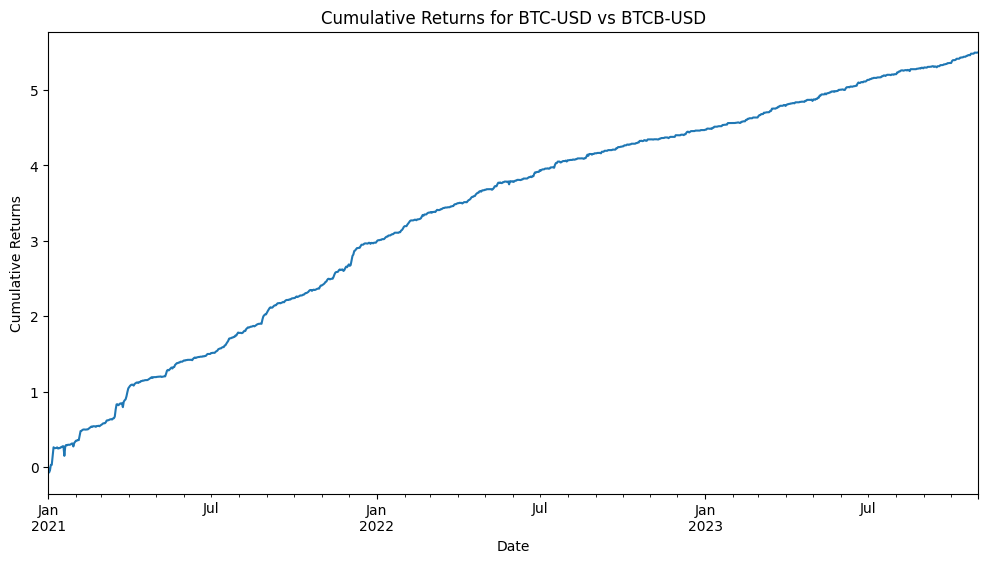

In [21]:

def optimize_parameters(data_sanitized, pairs):
    best_pair = None
    best_sharpe_ratio = -np.inf
    overall_cumulative_returns = 0

    entry_thresholds = np.linspace(0.1, 10.0, num=50)

    for pair in pairs:
        for entry_threshold in entry_thresholds:
            signals = generate_signals(data_sanitized, pair, entry_threshold)
            cumulative_returns, sharpe_ratio, positions = backtest_strategy(data_sanitized, pair, signals)
            if sharpe_ratio > best_sharpe_ratio:
                best_sharpe_ratio = sharpe_ratio
                best_pair = {
                    'pair': pair,
                    'entry_threshold': entry_threshold,
                    'sharpe_ratio': sharpe_ratio,
                    'cumulative_returns': cumulative_returns,
                    'positions': positions
                }
            overall_cumulative_returns += cumulative_returns.iloc[-1]

    return best_pair, overall_cumulative_returns, best_sharpe_ratio

cointegrated_pairs = [(pair[0], pair[1]) for pair in pairs]
best_pair, overall_cumulative_returns, best_sharpe_ratio = optimize_parameters(uts_sanitized, cointegrated_pairs)

print(f"Best Pair: {best_pair}")
print(f"Overall Cumulative Returns: {overall_cumulative_returns}")
print(f"Best Sharpe Ratio: {best_sharpe_ratio}")

best_cumulative_returns = best_pair['cumulative_returns']
pair_name = f"{best_pair['pair'][0]} vs {best_pair['pair'][1]}"
best_cumulative_returns.plot(title=f"Cumulative Returns for {pair_name}", figsize=(12, 6))
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.show()


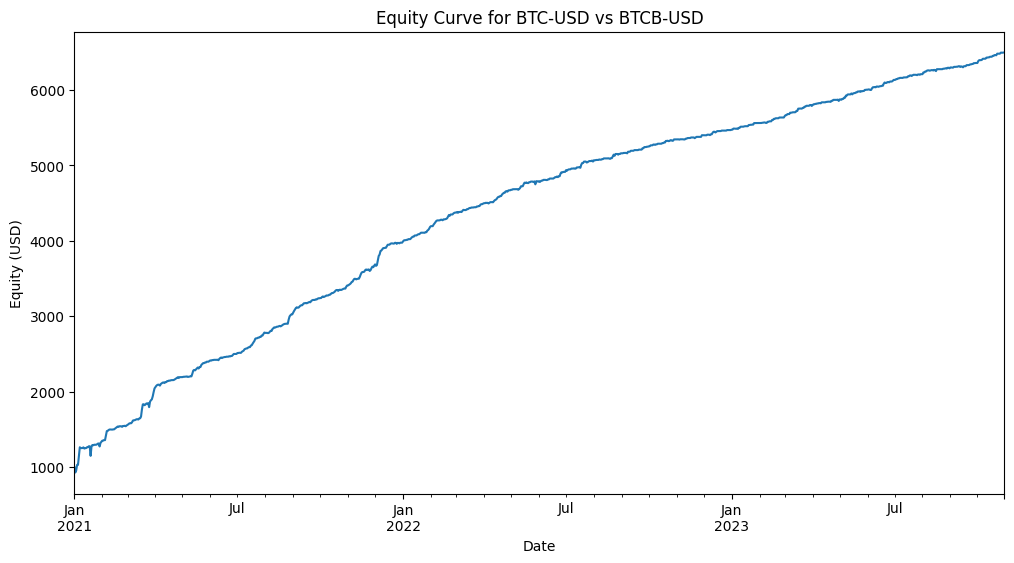

In [22]:
starting_balance = 1000
equity_curve = starting_balance * (1 + best_cumulative_returns)

# Plot equity curve
equity_curve.plot(title=f"Equity Curve for {pair_name}", figsize=(12, 6))
plt.xlabel('Date')
plt.ylabel('Equity (USD)')
plt.show()

In [23]:
final_balance = equity_curve.iloc[-1]
percentage_profit = ((final_balance - starting_balance) / starting_balance) * 100

print(f"Percentage Profit: {percentage_profit:.2f}%")

# Return the best pair, overall cumulative returns, best sharpe ratio, and percentage profit
result = {
    'best_pair': best_pair,
    'overall_cumulative_returns': overall_cumulative_returns,
    'best_sharpe_ratio': best_sharpe_ratio,
    'percentage_profit': percentage_profit
}

print(result)

Percentage Profit: 549.43%
{'best_pair': {'pair': ('BTC-USD', 'BTCB-USD'), 'entry_threshold': 0.1, 'sharpe_ratio': 3.365352443463978, 'cumulative_returns': 2021-01-01    0.000000
2021-01-02   -0.073108
2021-01-03   -0.044948
2021-01-04    0.028359
2021-01-05    0.028359
                ...   
2023-10-27    5.493029
2023-10-28    5.493029
2023-10-29    5.491298
2023-10-30    5.494267
2023-10-31    5.494267
Freq: D, Length: 1034, dtype: float64, 'positions':             BTC-USD  BTCB-USD
2021-01-01       -1         1
2021-01-02       -1         1
2021-01-03       -1         1
2021-01-04        0         0
2021-01-05        1        -1
...             ...       ...
2023-10-27        0         0
2023-10-28        1        -1
2023-10-29        1        -1
2023-10-30        1        -1
2023-10-31        1        -1

[1034 rows x 2 columns]}, 'overall_cumulative_returns': 17276.836541802495, 'best_sharpe_ratio': 3.365352443463978, 'percentage_profit': 549.426664419645}


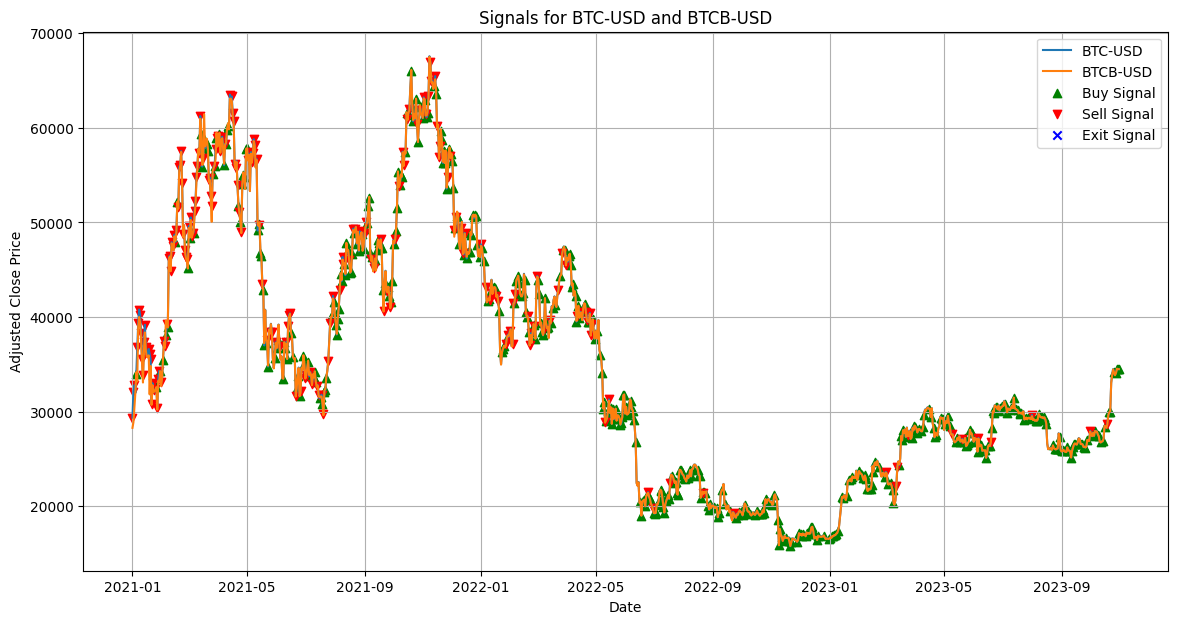

In [12]:
def plot_signals(data_sanitized, pair, signals):
    ticker1, ticker2 = pair[:2]
    plt.figure(figsize=(14, 7))

    plt.plot(data_sanitized[ticker1]['Adj Close'], label=ticker1)
    plt.plot(data_sanitized[ticker2]['Adj Close'], label=ticker2)

    buy_signals = signals[signals['long']]
    sell_signals = signals[signals['short']]
    exit_signals = signals[signals['exit']]

    plt.scatter(buy_signals.index, data_sanitized[ticker1].loc[buy_signals.index]['Adj Close'], marker='^', color='g', label='Buy Signal', alpha=1)
    plt.scatter(sell_signals.index, data_sanitized[ticker1].loc[sell_signals.index]['Adj Close'], marker='v', color='r', label='Sell Signal', alpha=1)
    plt.scatter(exit_signals.index, data_sanitized[ticker1].loc[exit_signals.index]['Adj Close'], marker='x', color='b', label='Exit Signal', alpha=1)

    plt.title(f'Signals for {ticker1} and {ticker2}')
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Adjusted Close Price')
    plt.grid(True)
    plt.show()

plot_signals(uts_sanitized, best_pair['pair'], generate_signals(uts_sanitized, best_pair['pair'], best_pair['entry_threshold']))
